In [42]:
data = [
    [12.0, 1.5, 1, 'Wine'],
    [5.0, 2.0, 0, 'Beer'],
    [40.0, 0.0, 1, 'Whiskey'],
    [13.5, 1.2, 1, 'Wine'],
    [4.5, 1.8, 0, 'Beer'],
    [38.0, 0.1, 1, 'Whiskey'],
    [11.5, 1.7, 1, 'Wine'],
    [5.5, 2.3, 0, 'Beer']
]

To split the dataset into features and labels(as numpy arrays) and to convert the labels to inetgers

In [77]:
import numpy as np
# last element of each row of the dataset is for labels
labels = [entry[-1] for entry in data]
# rest is for features
features = [entry[:-1] for entry in data]

# extract all the unique values, here 'Wine', 'Beer' , 'Whiskey'
unique_labels = np.unique(labels)
print(unique_labels)

# map 'Wine' to 2, 'Beer' to 0, 'Whiskey' to 1
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

# Convert the labels to integers using the label_mapping
labels = np.array([label_mapping[label] for label in labels])

# Convert the features to a numpy array
feature_matrix = np.array(features, dtype=float)


x = feature_matrix
y = labels





['Beer' 'Whiskey' 'Wine']


STEP 2: Function to find Gini Impurity

In [64]:
import numpy as np

def find_gini_impurity(labels):
    # unique_classes is all the unique values in the labels array and class_counts is count of all the unique values in the labels array
    unique_classes, class_counts = np.unique(labels, return_counts=True)

    # probability for each class
    class_probabilities = class_counts / len(labels)


    gini_impurity = 1 - np.sum(class_probabilities ** 2)

    return gini_impurity


Step 3: Implement the Best Split Finder

In [66]:
def best_split(x, y):

    best_gini = 1  # highest possible Gini value
    best_feature = None
    best_threshold = None

    # Iterate over all features
    for feature_index in range(x.shape[1]):


        # Get all possible thresholds (midpoints between consecutive sorted values)

        thresholds = np.unique(x[:, feature_index])

        for threshold in thresholds:


            # Split the dataset based on the threshold
            left_mask = x[:, feature_index] <= threshold
            right_mask = ~left_mask

            # Get the labels for each side
            left_labels = y[left_mask]
            right_labels = y[right_mask]

            # Check if the split is non-empty
            if len(left_labels) == 0 or len(right_labels) == 0:
                continue  # Skip this threshold since it results in an empty split

            # Compute Gini Impurity for both sides of the split
            left_gini = find_gini_impurity(left_labels)
            right_gini = find_gini_impurity(right_labels)

            # Weighted average Gini Impurity for the split
            gini = (len(left_labels) / len(y)) * left_gini + (len(right_labels) / len(y)) * right_gini



            # find min possible gini
            if gini < best_gini:
                best_gini = gini
                best_feature = feature_index
                best_threshold = threshold

    return best_feature, best_threshold


Step 4: Implement Recursive Tree Building


In [67]:
import numpy as np

def most_common_label(y):
    labels, counts = np.unique(y, return_counts=True)
    return labels[np.argmax(counts)]


In [88]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index  # Which feature to split on
        self.threshold = threshold          # Threshold value to split at
        self.left = left                    # Left subtree (X <= threshold)
        self.right = right                  # Right subtree (X > threshold)
        self.value = value                  # If it's a leaf, this is the predicted class

def build_tree(x,y,depth=0,max_depth = 3, min_samples = 2):

  # if max depth is reached
  if depth >= max_depth:
    leaf_value = most_common_label(y)
    return Node(value=leaf_value)

  # if all labels are same
  if len(np.unique(y)) == 1:
    return Node(value=y[0])

  # no of samples is below min_threshold
  if len(y) < min_samples:
    leaf_value = most_common_label(y)
    return Node(value=leaf_value)

  best_feature, best_threshold = best_split(x,y)

  if best_feature is None:
        return Node(value=most_common_label(y))

  # split the dataset
  left_indices = x[:, best_feature] <= best_threshold
  right_indices = ~left_indices

  # recursive calls: increase depth by 1
  left_subtree = build_tree(x[left_indices], y[left_indices], depth + 1, max_depth)
  right_subtree = build_tree(x[right_indices], y[right_indices], depth + 1, max_depth)

  return Node(
        feature_index=best_feature,
        threshold=best_threshold,
        left=left_subtree,
        right=right_subtree
    )




Step 5: Implement Prediction:
Traverse the tree recursively for each test point.
At a leaf node, return the stored class label.



In [89]:
def predict(node, x):
    #If we reach a leaf node, return the stored class label
    if node.value is not None:
        return node.value

    # Get the feature value for the test point
    feature_value = x[node.feature_index]

    #if feature value greater than threshold then go to the right otherwise go to the left,repeat recursively until leaf node is reached
    if feature_value <= node.threshold:
        return predict(node.left, x)
    else:
        return predict(node.right, x)

tree = build_tree(x,y)


In [90]:
test_data = np.array([
    [6.0, 2.1, 0],   # Expected: Beer
    [39.0, 0.05, 1], # Expected: Whiskey
    [13.0, 1.3, 1]   # Expected: Wine
])
predictions = [predict(tree, x_test) for x_test in test_data]

for p in predictions:
  if(int(p) == 2):
    print("Wine")
  elif(int(p) == 0):
    print("Beer")
  else:
    print("Whiskey")

Wine
Whiskey
Wine


(this is chatgpt generated)(i don't know matplotlib yet)

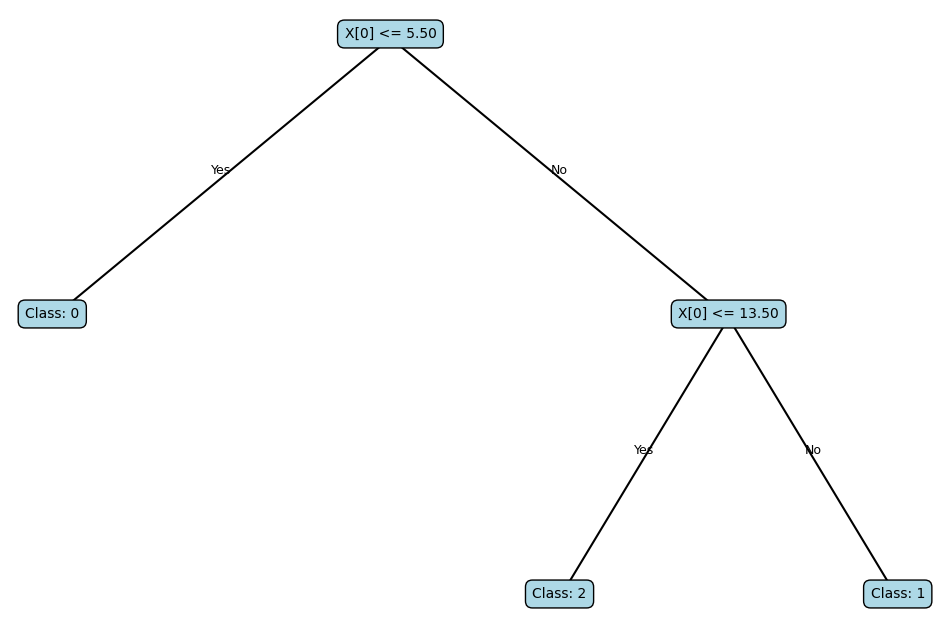

In [92]:
import matplotlib.pyplot as plt

def plot_tree(node, depth=0, pos=None, parent_pos=None, text='', x_offset=0.5, y_offset=1.5, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.set_axis_off()
        pos = (0.5, 1.0)

    # Label for the current node
    if node.value is not None:
        label = f'Class: {node.value}'
    else:
        label = f'X[{node.feature_index}] <= {node.threshold:.2f}'

    # Plot the node
    ax.text(pos[0], pos[1], label, ha='center', bbox=dict(facecolor='lightblue', boxstyle='round,pad=0.5'))

    # Draw edge from parent to current node
    if parent_pos:
        ax.plot([parent_pos[0], pos[0]], [parent_pos[1], pos[1]], 'k-')
        mid_x = (parent_pos[0] + pos[0]) / 2
        mid_y = (parent_pos[1] + pos[1]) / 2
        ax.text(mid_x, mid_y + 0.02, text, ha='center', fontsize=9)

    # Recursively draw children
    if node.left:
        left_pos = (pos[0] - x_offset / (2 ** depth), pos[1] - y_offset)
        plot_tree(node.left, depth + 1, left_pos, pos, 'Yes', x_offset, y_offset, ax)
    if node.right:
        right_pos = (pos[0] + x_offset / (2 ** depth), pos[1] - y_offset)
        plot_tree(node.right, depth + 1, right_pos, pos, 'No', x_offset, y_offset, ax)

    if depth == 0:
        plt.show()

plot_tree(tree)
